#Problem Statement:
##Autonomous vehicles (AV) and intelligent transport systems (ITS) are the future of road transport. Automatic detection of vehicles on the road in real-time is essential for vehicle tracking, vehicle counting, and road incident response.

In [1]:
# --- Import Libraries ---
import os
import cv2
import PIL
import glob
import shutil
import random
import requests
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#!rm -r '/content/Images'
#!rm -r '/content/yolov5'

In [4]:
# --- Unzip the images to train ---
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Simplilearn Projects/Autonomous Driving/Images.zip'

In [5]:
# --- Set variable for labels csv path ---
labels = ('/content/drive/MyDrive/Colab Notebooks/Simplilearn Projects/Autonomous Driving/labels.csv')

In [6]:
# --- Read the dataset ---
label = pd.read_csv(labels)
label.head(10)

00000000       pickup_truck  213   34  255   50
0         0                car  194   78  273  122
1         0                car  155   27  183   35
2         0  articulated_truck   43   25  109   55
3         0                car  106   32  124   45
4         1                bus  205  155  568  314
5         1                bus  285  123  477  168
6         1                car  544  162  617  193
7         1                car  329  152  371  163
8         1                car  447  161  497  183
9         1                car  662  199  715  236

In [7]:
# --- Inspect data ---
label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351548 entries, 0 to 351547
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   00000000      351548 non-null  int64 
 1   pickup_truck  351548 non-null  object
 2   213           351548 non-null  int64 
 3   34            351548 non-null  int64 
 4   255           351548 non-null  int64 
 5   50            351548 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 16.1+ MB


In [8]:
# --- Inspect data ---
view = label['pickup_truck'].unique()
view

array(['car', 'articulated_truck', 'bus', 'motorized_vehicle',
       'pickup_truck', 'work_van', 'single_unit_truck', 'pedestrian',
       'bicycle', 'non-motorized_vehicle', 'motorcycle'], dtype=object)

In [9]:
# --- Add column names to data ---
col_names = ['index', 'class_name', 'xmin', 'ymin', 'xmax', 'ymax']

label = pd.read_csv(labels, names=col_names)
label.head(10)

index         class_name  xmin  ymin  xmax  ymax
0      0       pickup_truck   213    34   255    50
1      0                car   194    78   273   122
2      0                car   155    27   183    35
3      0  articulated_truck    43    25   109    55
4      0                car   106    32   124    45
5      1                bus   205   155   568   314
6      1                bus   285   123   477   168
7      1                car   544   162   617   193
8      1                car   329   152   371   163
9      1                car   447   161   497   183

In [10]:
#!rm -r '/content/yolo_dataset'

In [11]:
#!rm -r '/content/yolov5'

# Creating Python script for the following


1.   Creates train, test and valid directories
2.   Clones the Yolov5 to yolov5 local directory
3.   Reads and processes your labels.csv: It takes your raw bounding box data.
4.   Splits the image IDs: It divides your dataset's image IDs into distinct train, test, and validation sets based on the ratios you defined.
5.   Copies images: It copies the actual image files into the newly created images/train, images/test, images/valid directories.
6.  Converts and Writes YOLO Labels: This is a crucial step! It reads the bounding box coordinates from your CSV, converts them into the normalized YOLO format (class_id, center_x, center_y, width, height), and writes them to .txt files in the labels/train, labels/test, labels/valid directories.
7.   Generates data.yaml: It dynamically creates the data.yaml configuration file that YOLOv5 needs to understand your dataset's structure, class names, and paths.
8.  Runs YOLOv5 Training: It executes the train.py script from the cloned YOLOv5 repository, using your data.yaml and pre-trained weights, to train the object detection model on your custom dataset. It also uses the GPU (--device 0) and a specified batch size.
9. Shows Validation Prediction Images: After training, it displays a limited number of prediction images from the validation set, showing how the model performed during training
10. Runs YOLOv5 Inference on Test Data: It executes the detect.py script on the test portion of your dataset, applying the trained model to find objects.

11.  Visualizes Inference Results: It displays a limited number of images from the inference run, showing the detected objects with bounding boxes and confidence scores.

In [24]:
%%writefile /content/split_dataset.py
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import glob
import cv2
import matplotlib.pyplot as plt

# --- Setting configuration ---
IMAGE_DIR = '/content/Images'
LABELS_CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/Simplilearn Projects/Autonomous Driving/labels.csv'
OUTPUT_BASE_DIR = 'yolo_dataset'

TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VALID_RATIO = 0.1

RANDOM_SEED = 42
epochs = 5

# --- Class name mapping ---
CLASS_NAMES = ['car', 'articulated_truck', 'bus', 'motorized_vehicle',
               'pickup_truck', 'work_van', 'single_unit_truck', 'pedestrian',
               'bicycle', 'non-motorized_vehicle', 'motorcycle']
class_name_to_id = {name: i for i, name in enumerate(CLASS_NAMES)}

# --- Create Output Directories for your split dataset ---
def create_split_dataset_dirs(base_dir, subfolders=['train', 'test', 'valid']):
    base_images_path = os.path.join(base_dir, 'images')
    base_labels_path = os.path.join(base_dir, 'labels')
    os.makedirs(base_images_path, exist_ok=True)
    os.makedirs(base_labels_path, exist_ok=True)
    print(f"Created base images dir: {base_images_path} exists: {os.path.exists(base_images_path)}")
    print(f"Created base labels dir: {base_labels_path} exists: {os.path.exists(base_labels_path)}")
    for folder in subfolders:
        img_path = os.path.join(base_dir, 'images', folder)
        lbl_path = os.path.join(base_dir, 'labels', folder)
        os.makedirs(img_path, exist_ok=True)
        os.makedirs(lbl_path, exist_ok=True)
        print(f"Created {folder}/images dir: {img_path} exists: {os.path.exists(img_path)}")
        print(f"Created {folder}/labels dir: {lbl_path} exists: {os.path.exists(lbl_path)}")


# --- Helper function to convert and write YOLO labels ---
def convert_and_write_yolo_labels(image_id, group_df, dest_label_path, image_width, image_height):
    """
    Converts bounding box data from DataFrame row to YOLO format and writes to file.
    """
    with open(dest_label_path, 'w') as f:
        for _, row in group_df.iterrows():
            class_name = row['class_name']
            xmin = row['xmin']
            ymin = row['ymin']
            xmax = row['xmax']
            ymax = row['ymax']

            class_id = class_name_to_id.get(class_name, -1)
            if class_id == -1:
                print(f"Warning: Unknown class '{class_name}' for image {image_id}. Skipping bounding box.")
                continue

            # Convert (xmin, ymin, xmax, ymax) to (center_x, center_y, width, height)
            box_width = xmax - xmin
            box_height = ymax - ymin
            center_x = xmin + (box_width / 2)
            center_y = ymin + (box_height / 2)

            # Normalize coordinates
            norm_center_x = center_x / image_width
            norm_center_y = center_y / image_height
            norm_width = box_width / image_width
            norm_height = box_height / image_height

            f.write(f'{class_id} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}\n')

# --- Function to find the latest YOLOv5 experiment results directory ---

def get_latest_yolov5_run_dir():
    runs_train_base = os.path.join(os.getcwd(), 'runs', 'train') # /content/yolov5/runs/train
    if not os.path.exists(runs_train_base):
        print(f"Warning: YOLOv5 runs/train directory not found at {runs_train_base}")
        return None

    exp_dirs = [d for d in os.listdir(runs_train_base) if d.startswith('exp') and os.path.isdir(os.path.join(runs_train_base, d))]
    if not exp_dirs:
        print(f"No 'exp' directories found in {runs_train_base}. Check if training created a custom-named directory.")
        return None

    # Sort numerically (exp1, exp2, exp10) and pick the last one
    exp_dirs.sort(key=lambda x: int(x.replace('exp', '')) if x.replace('exp', '').isdigit() else 0)
    latest_exp_dir_name = exp_dirs[-1]

    return os.path.join(runs_train_base, latest_exp_dir_name)

# --- Define a function to show validation predictions saved during training ---
def show_validation_images(yolov5_results_dir, limit=3): # Renamed parameter for clarity
  if not yolov5_results_dir or not os.path.exists(yolov5_results_dir):
      print(f"Error: YOLOv5 results directory not found or invalid: {yolov5_results_dir}")
      return

  print(f"Attempting to list contents of: {yolov5_results_dir}")
  #os.system(f'ls "{yolov5_results_dir}"')

  EXPORT_PATH = yolov5_results_dir
  validation_pred_images = glob.glob(f"{EXPORT_PATH}/*_pred.jpg")
  print(f"Found validation prediction images: {len(validation_pred_images)}")

  if not validation_pred_images:
      print(f"No *_pred.jpg images found in {EXPORT_PATH}. Double-check YOLOv5's output.")
      return

  images_to_display = validation_pred_images[:limit]
  print(f"Displaying the {len(images_to_display)} images out of {len(validation_pred_images)}.")

  for pred_image in images_to_display:
    image = cv2.imread(pred_image)
    if image is not None:
        plt.figure(figsize=(10, 10))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.title(os.path.basename(pred_image))
        plt.show()
    else:
        print(f"Warning: Could not read image {pred_image}. It might be corrupted or not a valid image file.")

# --- Define a helper function for inference on images ---
def inference(yolov5_results_dir, data_path): # Renamed parameter for clarity
    if not yolov5_results_dir:
        print("Error: YOLOv5 results directory is not valid for inference.")
        return

    infer_base_dir = os.path.join(os.getcwd(), 'runs', 'detect') # /content/yolov5/runs/detect
    os.makedirs(infer_base_dir, exist_ok=True) # Ensure it exists

    infer_dir_count = len([d for d in os.listdir(infer_base_dir) if os.path.isdir(os.path.join(infer_base_dir, d))])
    print(f"Current number of inference directories {infer_dir_count}")
    INFER_NAME = f"inference_{infer_dir_count+1}" # This is the name for the output folder

    # Path to best.pt weights
    weights_path = os.path.join(yolov5_results_dir, 'weights', 'best.pt')
    if not os.path.exists(weights_path):
        print(f"Error: best.pt weights not found at {weights_path}. Check training output.")
        return

    print(f"Running inference, output will be in: {os.path.join(infer_base_dir, INFER_NAME)}")
    os.system(f'python3 detect.py --weights "{weights_path}" '
          f'--source "{data_path}" --name "{INFER_NAME}" --project "{infer_base_dir}" --exist-ok')

    return os.path.join(infer_base_dir, INFER_NAME) # Return the full path to the inference results

# --- Visualize inference images ---
def visualize_inference_images(INFER_RESULTS_DIR, limit=3): # Renamed parameter for clarity
    if not INFER_RESULTS_DIR or not os.path.exists(INFER_RESULTS_DIR):
        print(f"Error: Inference results directory not found or invalid: {INFER_RESULTS_DIR}")
        return

    print(f"Attempting to visualize images from: {INFER_RESULTS_DIR}")
    infer_images = glob.glob(f"{INFER_RESULTS_DIR}/*.jpg")
    print(f"Found inference images: {len(infer_images)}")

    if not infer_images:
        print(f"No .jpg images found in {INFER_RESULTS_DIR}.")
        return

    images_to_display = infer_images[:limit]
    print(f"Displaying the {len(images_to_display)} images out of {len(infer_images)}.")

    for pred_image in images_to_display:
        image = cv2.imread(pred_image)
        if image is not None:
            plt.figure(figsize=(10, 10))
            plt.imshow(image[:, :, ::-1])
            plt.axis('off')
            plt.title(os.path.basename(pred_image))
            plt.show()
        else:
            print(f"Warning: Could not read image {pred_image}.")


# --- Main Execution Flow ---
if __name__ == "__main__":
    # Ensure all necessary libraries are installed
    if not os.path.exists('/content/yolov5'):
        os.system('git clone https://github.com/ultralytics/yolov5.git /content/yolov5') # Clone to /content/yolov5
    os.chdir('/content/yolov5') # Ensure you are in the yolov5 directory
    os.system('pip install -r requirements.txt')


    # Create your custom dataset split directories first
    # This was originally `create_dirs(OUTPUT_BASE_DIR)`, changed to `create_split_dataset_dirs`
    # for consistent naming as defined above.
    create_split_dataset_dirs(OUTPUT_BASE_DIR)

    # --- Your data splitting logic ---
    try:
        col_names = ['index', 'class_name', 'xmin', 'ymin', 'xmax', 'ymax']
        labels_df = pd.read_csv(LABELS_CSV_PATH, names=col_names)
        print(f"Successfully loaded labels from: {LABELS_CSV_PATH}")
    except Exception as e:
        print(f"Error loading CSV for splitting: {e}")
        exit()

    unique_image_ids = labels_df['index'].unique()
    if len(unique_image_ids) == 0:
        print("No unique image IDs found. Exiting dataset split.")
        exit()

    train_ids, temp_ids = train_test_split(unique_image_ids, test_size=(TEST_RATIO + VALID_RATIO), random_state=RANDOM_SEED, shuffle=True)
    test_ids, valid_ids = train_test_split(temp_ids, test_size=(VALID_RATIO / (TEST_RATIO + VALID_RATIO)), random_state=RANDOM_SEED, shuffle=True)

    split_datasets = {'train': train_ids, 'test': test_ids, 'valid': valid_ids}

    for split_name, ids_list in split_datasets.items():
        print(f"\nProcessing {split_name} dataset...")
        for image_id in ids_list:
            image_filename = f'{image_id:08d}.jpg'
            source_image_path = os.path.join(IMAGE_DIR, image_filename)

            dest_image_dir = os.path.join(OUTPUT_BASE_DIR, 'images', split_name)
            dest_label_dir = os.path.join(OUTPUT_BASE_DIR, 'labels', split_name)
            dest_image_path = os.path.join(dest_image_dir, image_filename)
            dest_label_path = os.path.join(dest_label_dir, f'{image_id:08d}.txt')

            if not os.path.exists(source_image_path):
                print(f"Warning: Image not found: {source_image_path}. Skipping.")
                continue

            try:
                with Image.open(source_image_path) as img:
                    image_width, image_height = img.size
            except Exception as e:
                print(f"Error reading image dimensions for {source_image_path}: {e}. Skipping.")
                continue

            shutil.copy(source_image_path, dest_image_path)
            print(f"Copied image {image_filename} to {dest_image_path}. Exists: {os.path.exists(dest_image_path)}")
            image_labels_df = labels_df[labels_df['index'] == image_id]
            convert_and_write_yolo_labels(image_id, image_labels_df, dest_label_path, image_width, image_height)
            print(f"Wrote label {f'{image_id:08d}.txt'} to {dest_label_path}. Exists: {os.path.exists(dest_label_path)}")
    print("\nDataset splitting and YOLO label generation complete!")
    print(f"Check your '{OUTPUT_BASE_DIR}' directory.")


    # --- Prepare data.yaml for YOLOv5 ---
    data_yaml_content = f"""
    path: ./yolo_dataset
    train: images/train
    val: images/valid
    test: images/test

    nc: {len(CLASS_NAMES)}
    names: {CLASS_NAMES}
    """
    DATA_YAML_PATH = '../data.yaml'
    with open(DATA_YAML_PATH, 'w') as f:
        f.write(data_yaml_content)
    print(f"\nCreated data.yaml at {DATA_YAML_PATH}")
    print(data_yaml_content)


    # --- Run YOLOv5 training ---
    YOLO_TRAIN_NAME = 'my_custom_run'
    print(f"\nStarting YOLOv5 training. Results will be in runs/train/{YOLO_TRAIN_NAME} (relative to /content/yolov5)")
    os.system(f'python3 train.py --data {DATA_YAML_PATH} --weights yolov5s.pt '
              f'--img 320 --epochs {epochs} --batch-size 32 --name {YOLO_TRAIN_NAME} --project runs/train --device 0')

    # --- After Training: Get the actual YOLOv5 results directory ---

    ACTUAL_YOLOV5_TRAIN_RESULTS_DIR = os.path.join(os.getcwd(), 'runs', 'train', YOLO_TRAIN_NAME)
    if not os.path.exists(ACTUAL_YOLOV5_TRAIN_RESULTS_DIR):
        ACTUAL_YOLOV5_TRAIN_RESULTS_DIR = get_latest_yolov5_run_dir()
    print(f"Actual YOLOv5 training results directory: {ACTUAL_YOLOV5_TRAIN_RESULTS_DIR}")


    # --- Show Validation Images ---
    show_validation_images(ACTUAL_YOLOV5_TRAIN_RESULTS_DIR)

    # --- Run Inference ---

    relative_inference_source_path = os.path.join(OUTPUT_BASE_DIR, 'images', 'test')
    ABSOLUTE_INFERENCE_SOURCE_PATH = os.path.abspath(relative_inference_source_path)

    if not os.path.exists(ABSOLUTE_INFERENCE_SOURCE_PATH):
        print(f"Critical Error: Inference source path not found: {ABSOLUTE_INFERENCE_SOURCE_PATH}")
        print("Please ensure your 'yolo_dataset' and its 'test/images' folder are correctly set up.")
        ACTUAL_YOLOV5_INFER_RESULTS_DIR =None
    else:
        print(f"Inference source path CONFIRMED to exist: {ABSOLUTE_INFERENCE_SOURCE_PATH}")

    print(f"\nRunning inference on test images from: {ABSOLUTE_INFERENCE_SOURCE_PATH}")
    ACTUAL_YOLOV5_INFER_RESULTS_DIR = inference(ACTUAL_YOLOV5_TRAIN_RESULTS_DIR, ABSOLUTE_INFERENCE_SOURCE_PATH)

    # --- Visualize Inference Images ---
    if ACTUAL_YOLOV5_INFER_RESULTS_DIR:
        visualize_inference_images(ACTUAL_YOLOV5_INFER_RESULTS_DIR, limit=3)
    else:
        print("Inference results directory not found for visualization.")

    print("\nScript execution finished!")

Overwriting /content/split_dataset.py


In [25]:
!python /content/split_dataset.py

Streaming output truncated to the last 5000 lines.
Copied image 00004572.jpg to yolo_dataset/images/valid/00004572.jpg. Exists: True
Wrote label 00004572.txt to yolo_dataset/labels/valid/00004572.txt. Exists: True
Copied image 00004308.jpg to yolo_dataset/images/valid/00004308.jpg. Exists: True
Wrote label 00004308.txt to yolo_dataset/labels/valid/00004308.txt. Exists: True
Copied image 00001266.jpg to yolo_dataset/images/valid/00001266.jpg. Exists: True
Wrote label 00001266.txt to yolo_dataset/labels/valid/00001266.txt. Exists: True
Copied image 00000990.jpg to yolo_dataset/images/valid/00000990.jpg. Exists: True
Wrote label 00000990.txt to yolo_dataset/labels/valid/00000990.txt. Exists: True
Copied image 00004603.jpg to yolo_dataset/images/valid/00004603.jpg. Exists: True
Wrote label 00004603.txt to yolo_dataset/labels/valid/00004603.txt. Exists: True
Copied image 00001892.jpg to yolo_dataset/images/valid/00001892.jpg. Exists: True
Wrote label 00001892.txt to yolo_dataset/labels/vali

#Evaluate the model and check the test results

In [31]:
import os
%cd /content/yolov5/runs/train/my_custom_run
#!ls -lh

/content/yolov5/runs/train/my_custom_run


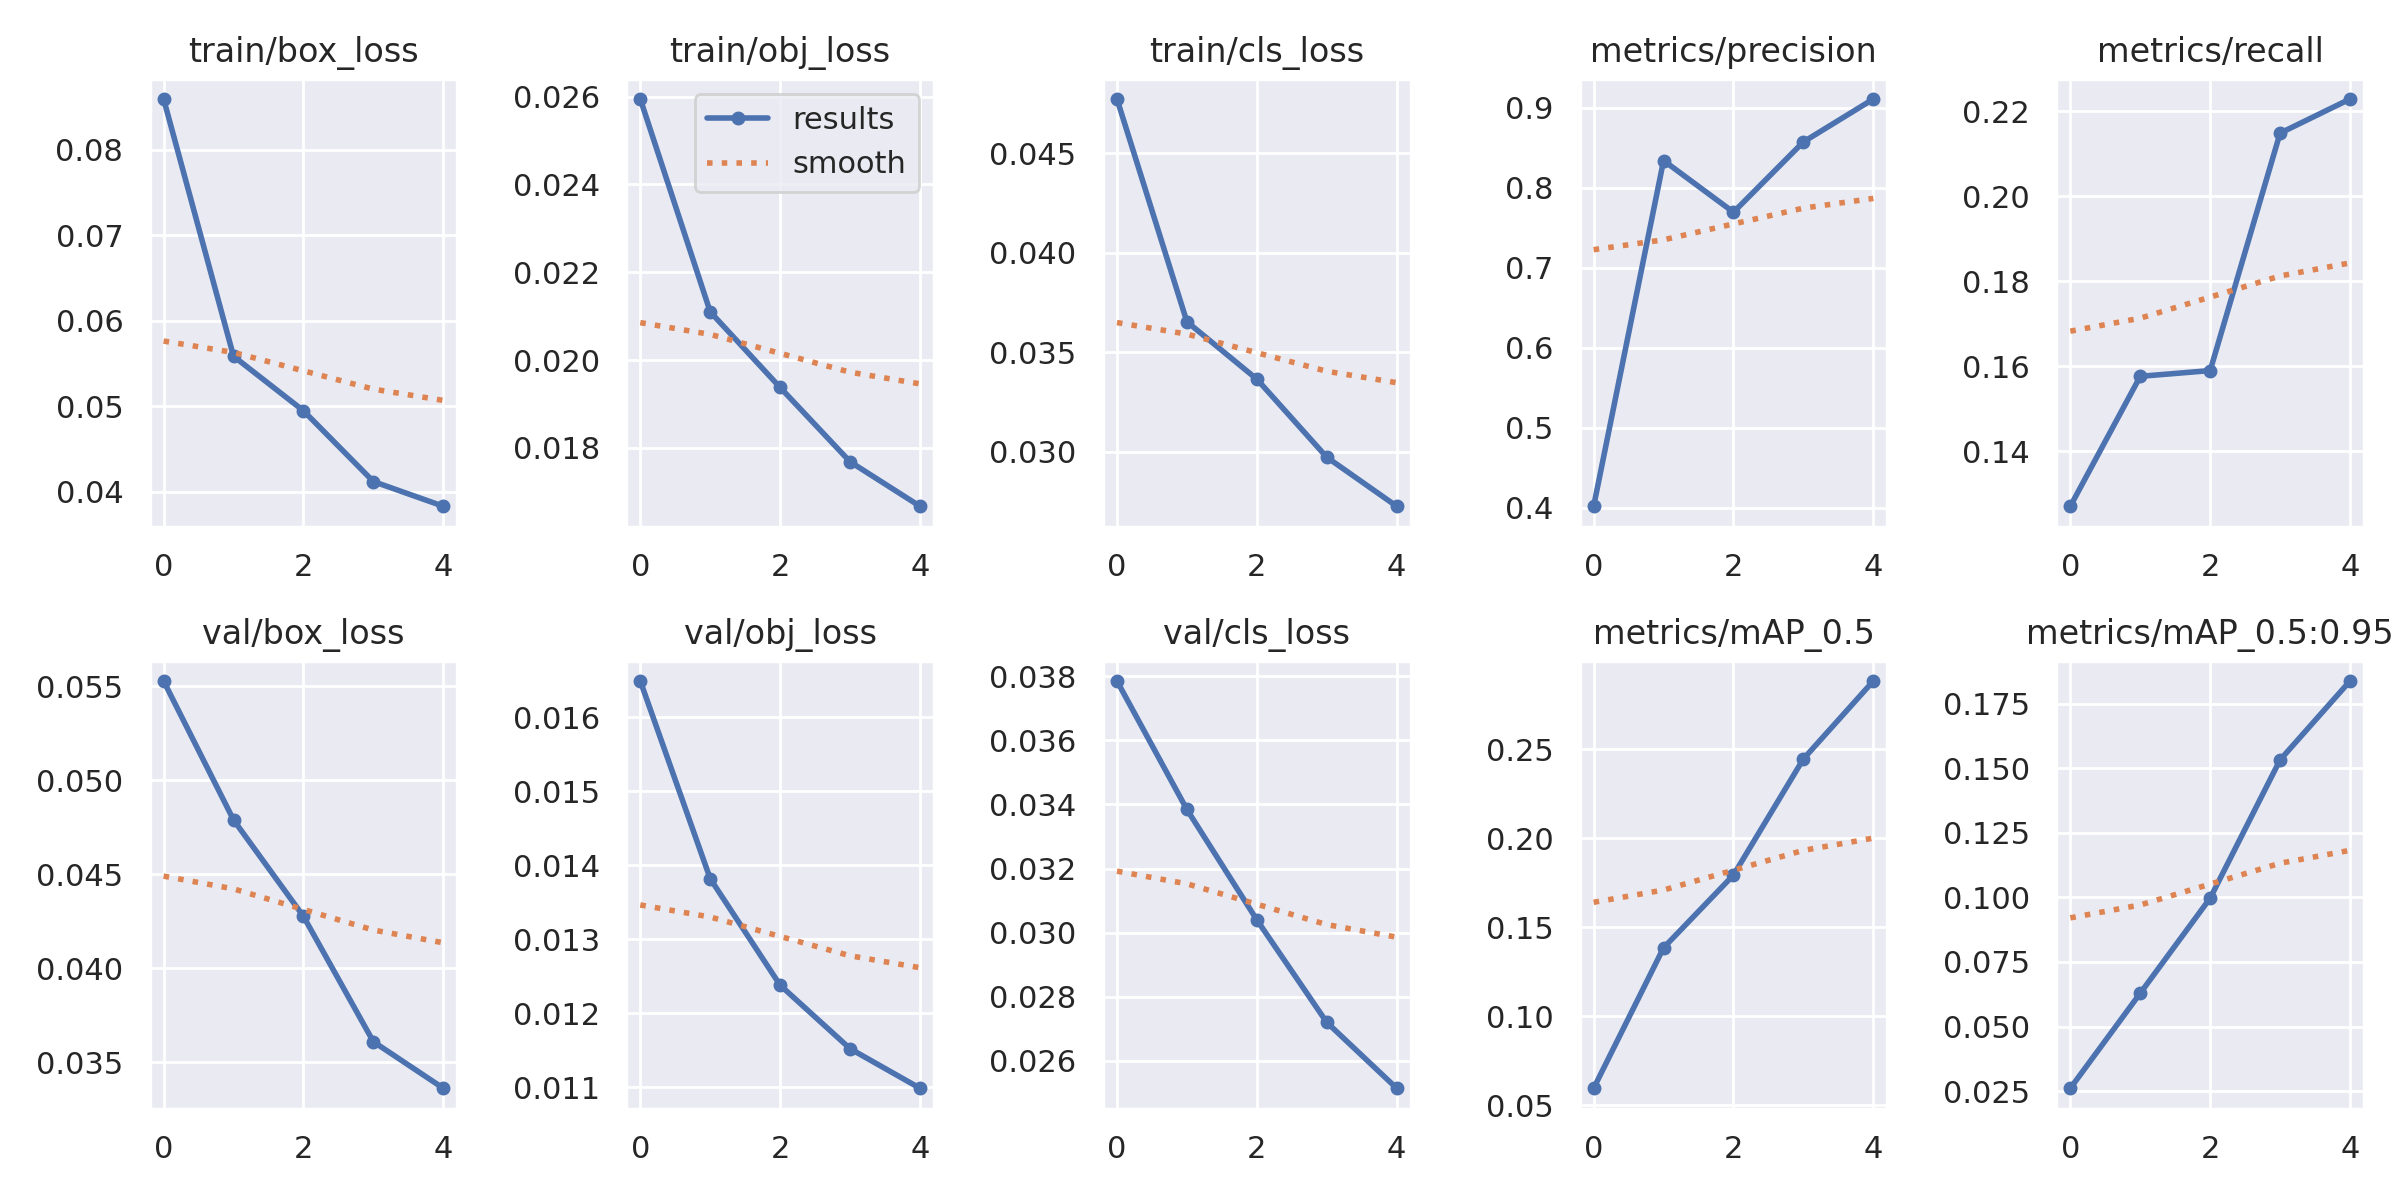

In [30]:
from IPython.display import Image, display
display(Image(filename='/content/yolov5/runs/train/my_custom_run/results.png', width=1000))

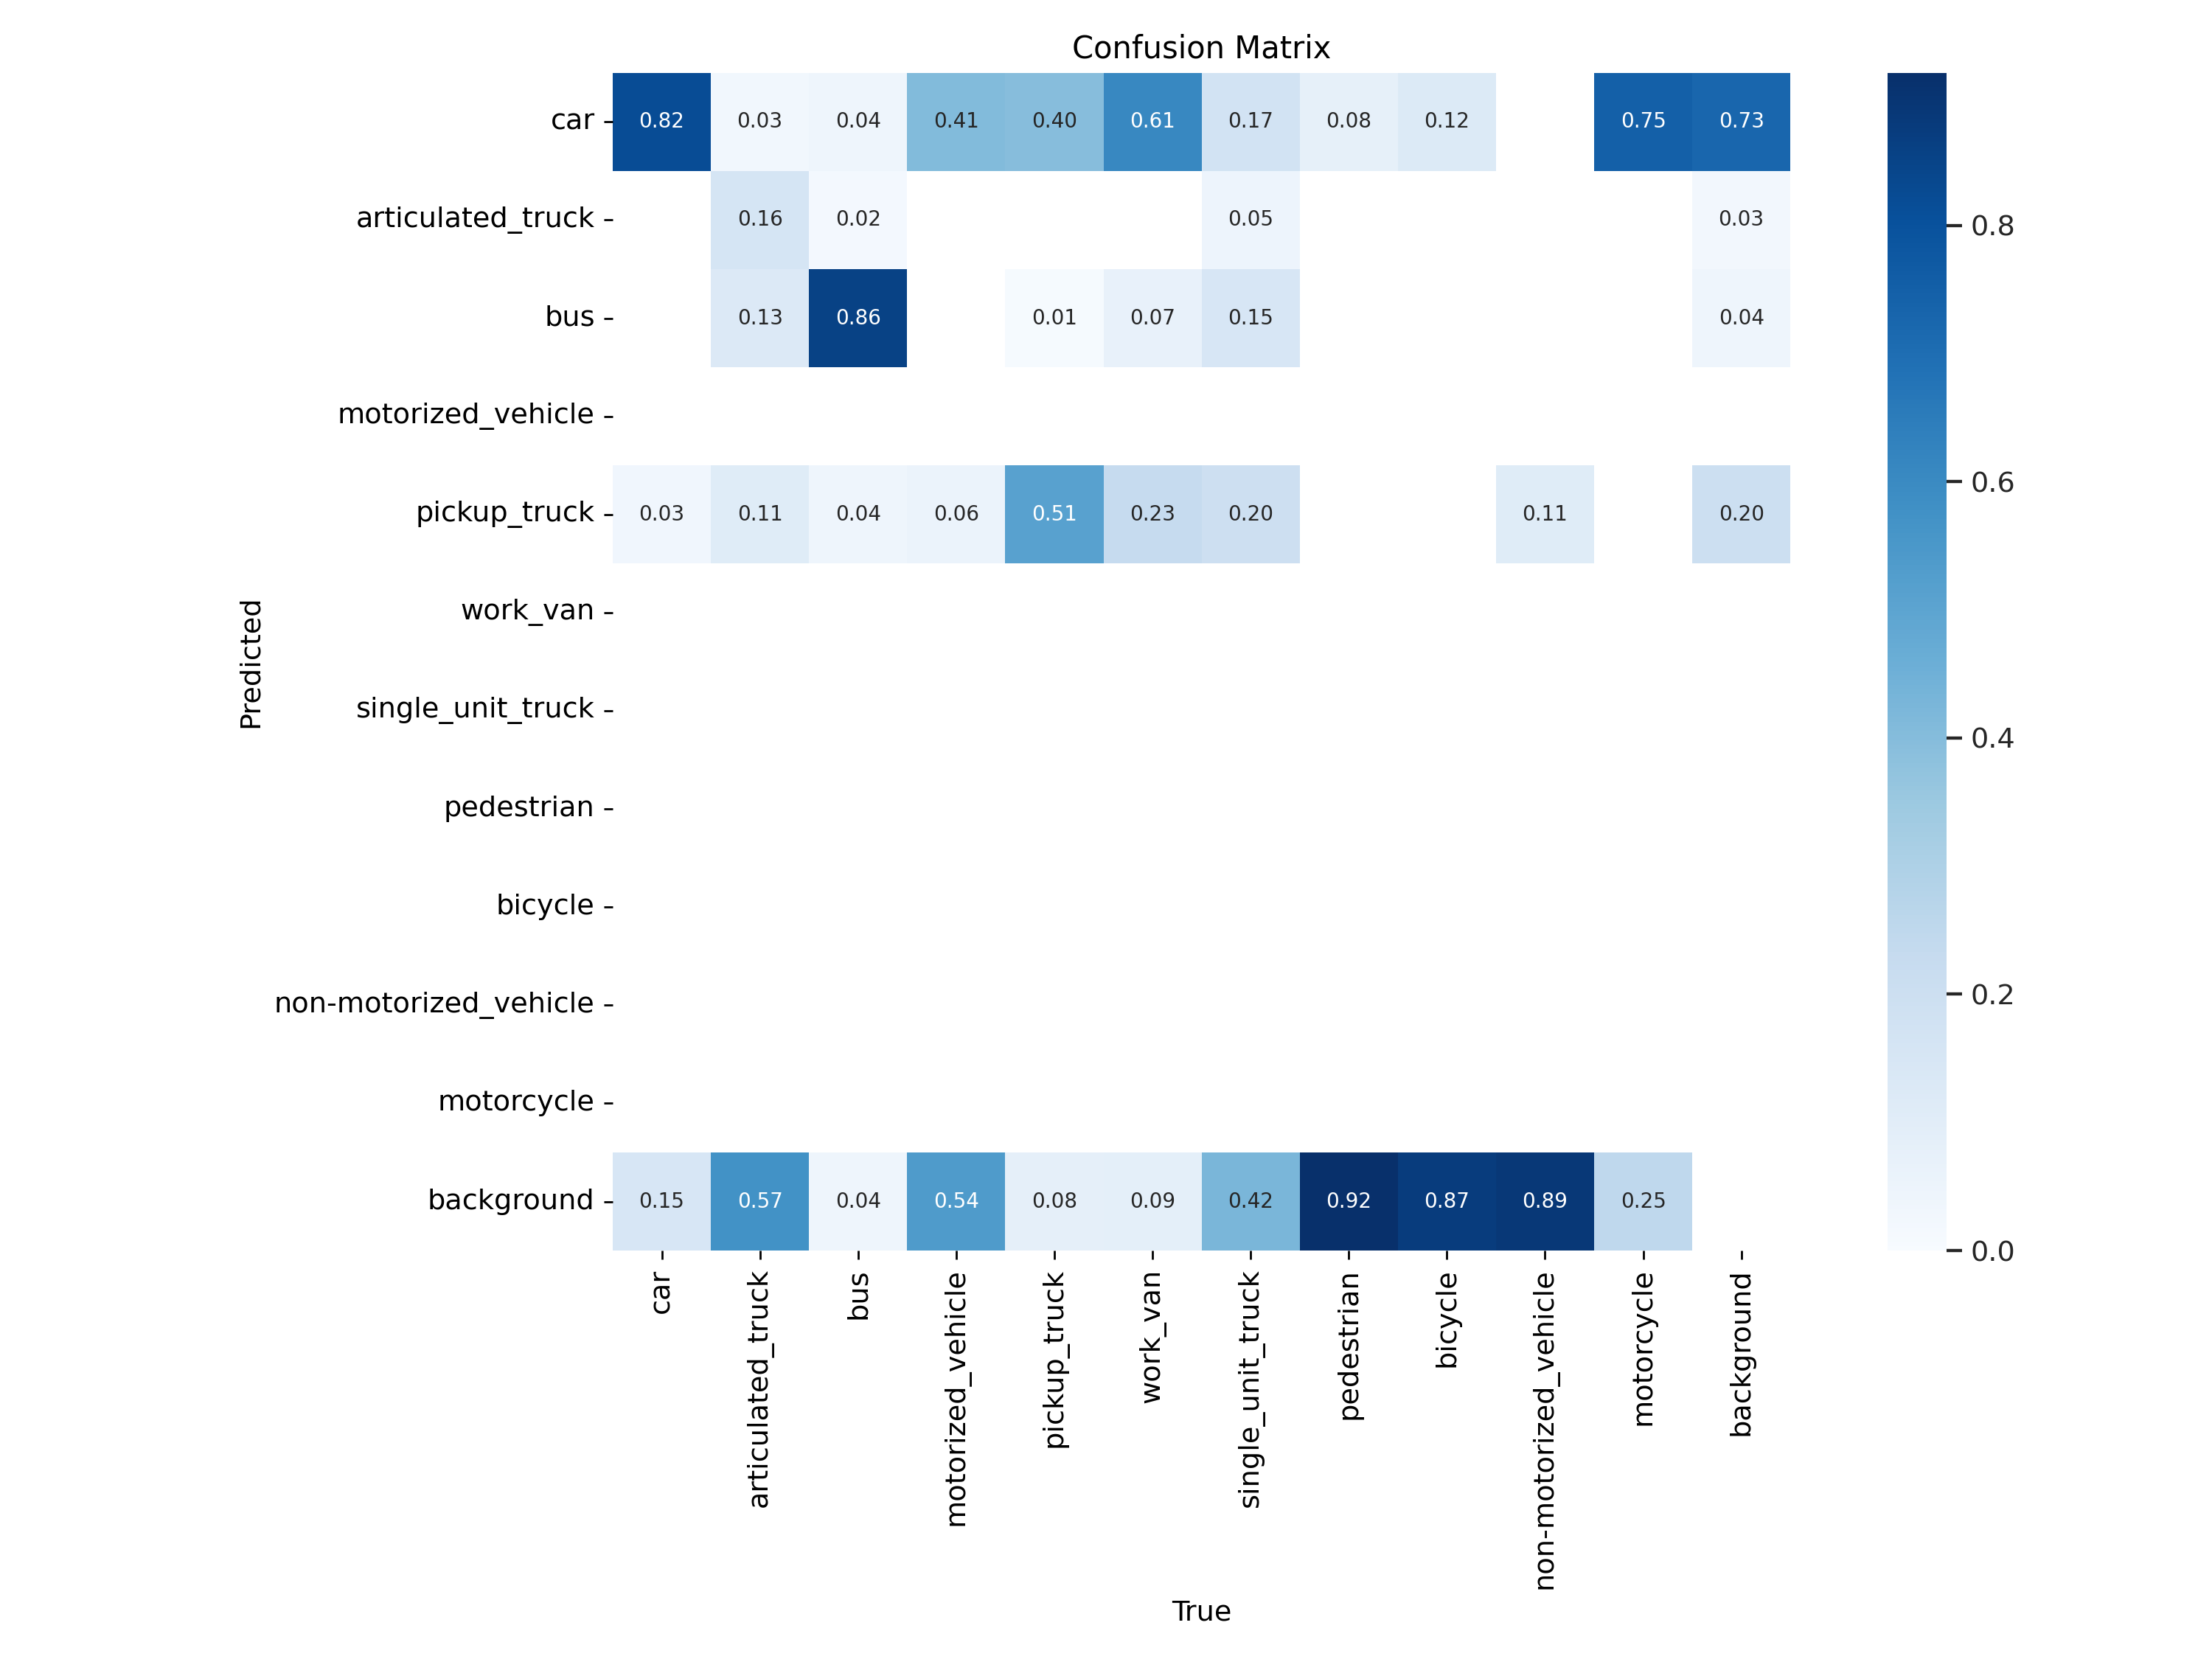

In [28]:
display(Image(filename='/content/yolov5/runs/train/my_custom_run/confusion_matrix.png', width=800))


# Confusion Matrix Interpretation:
- 86% of actual buses are correctly identified (Predicted: bus, True: bus is 0.86)
- 51% of actual pickup trucks are correctly identified (Predicted: pickup_truck, True: pickup_truck is 0.51)
- 51% of actual pickup trucks are correctly identified (Predicted: pickup_truck, True: pickup_truck is 0.51)

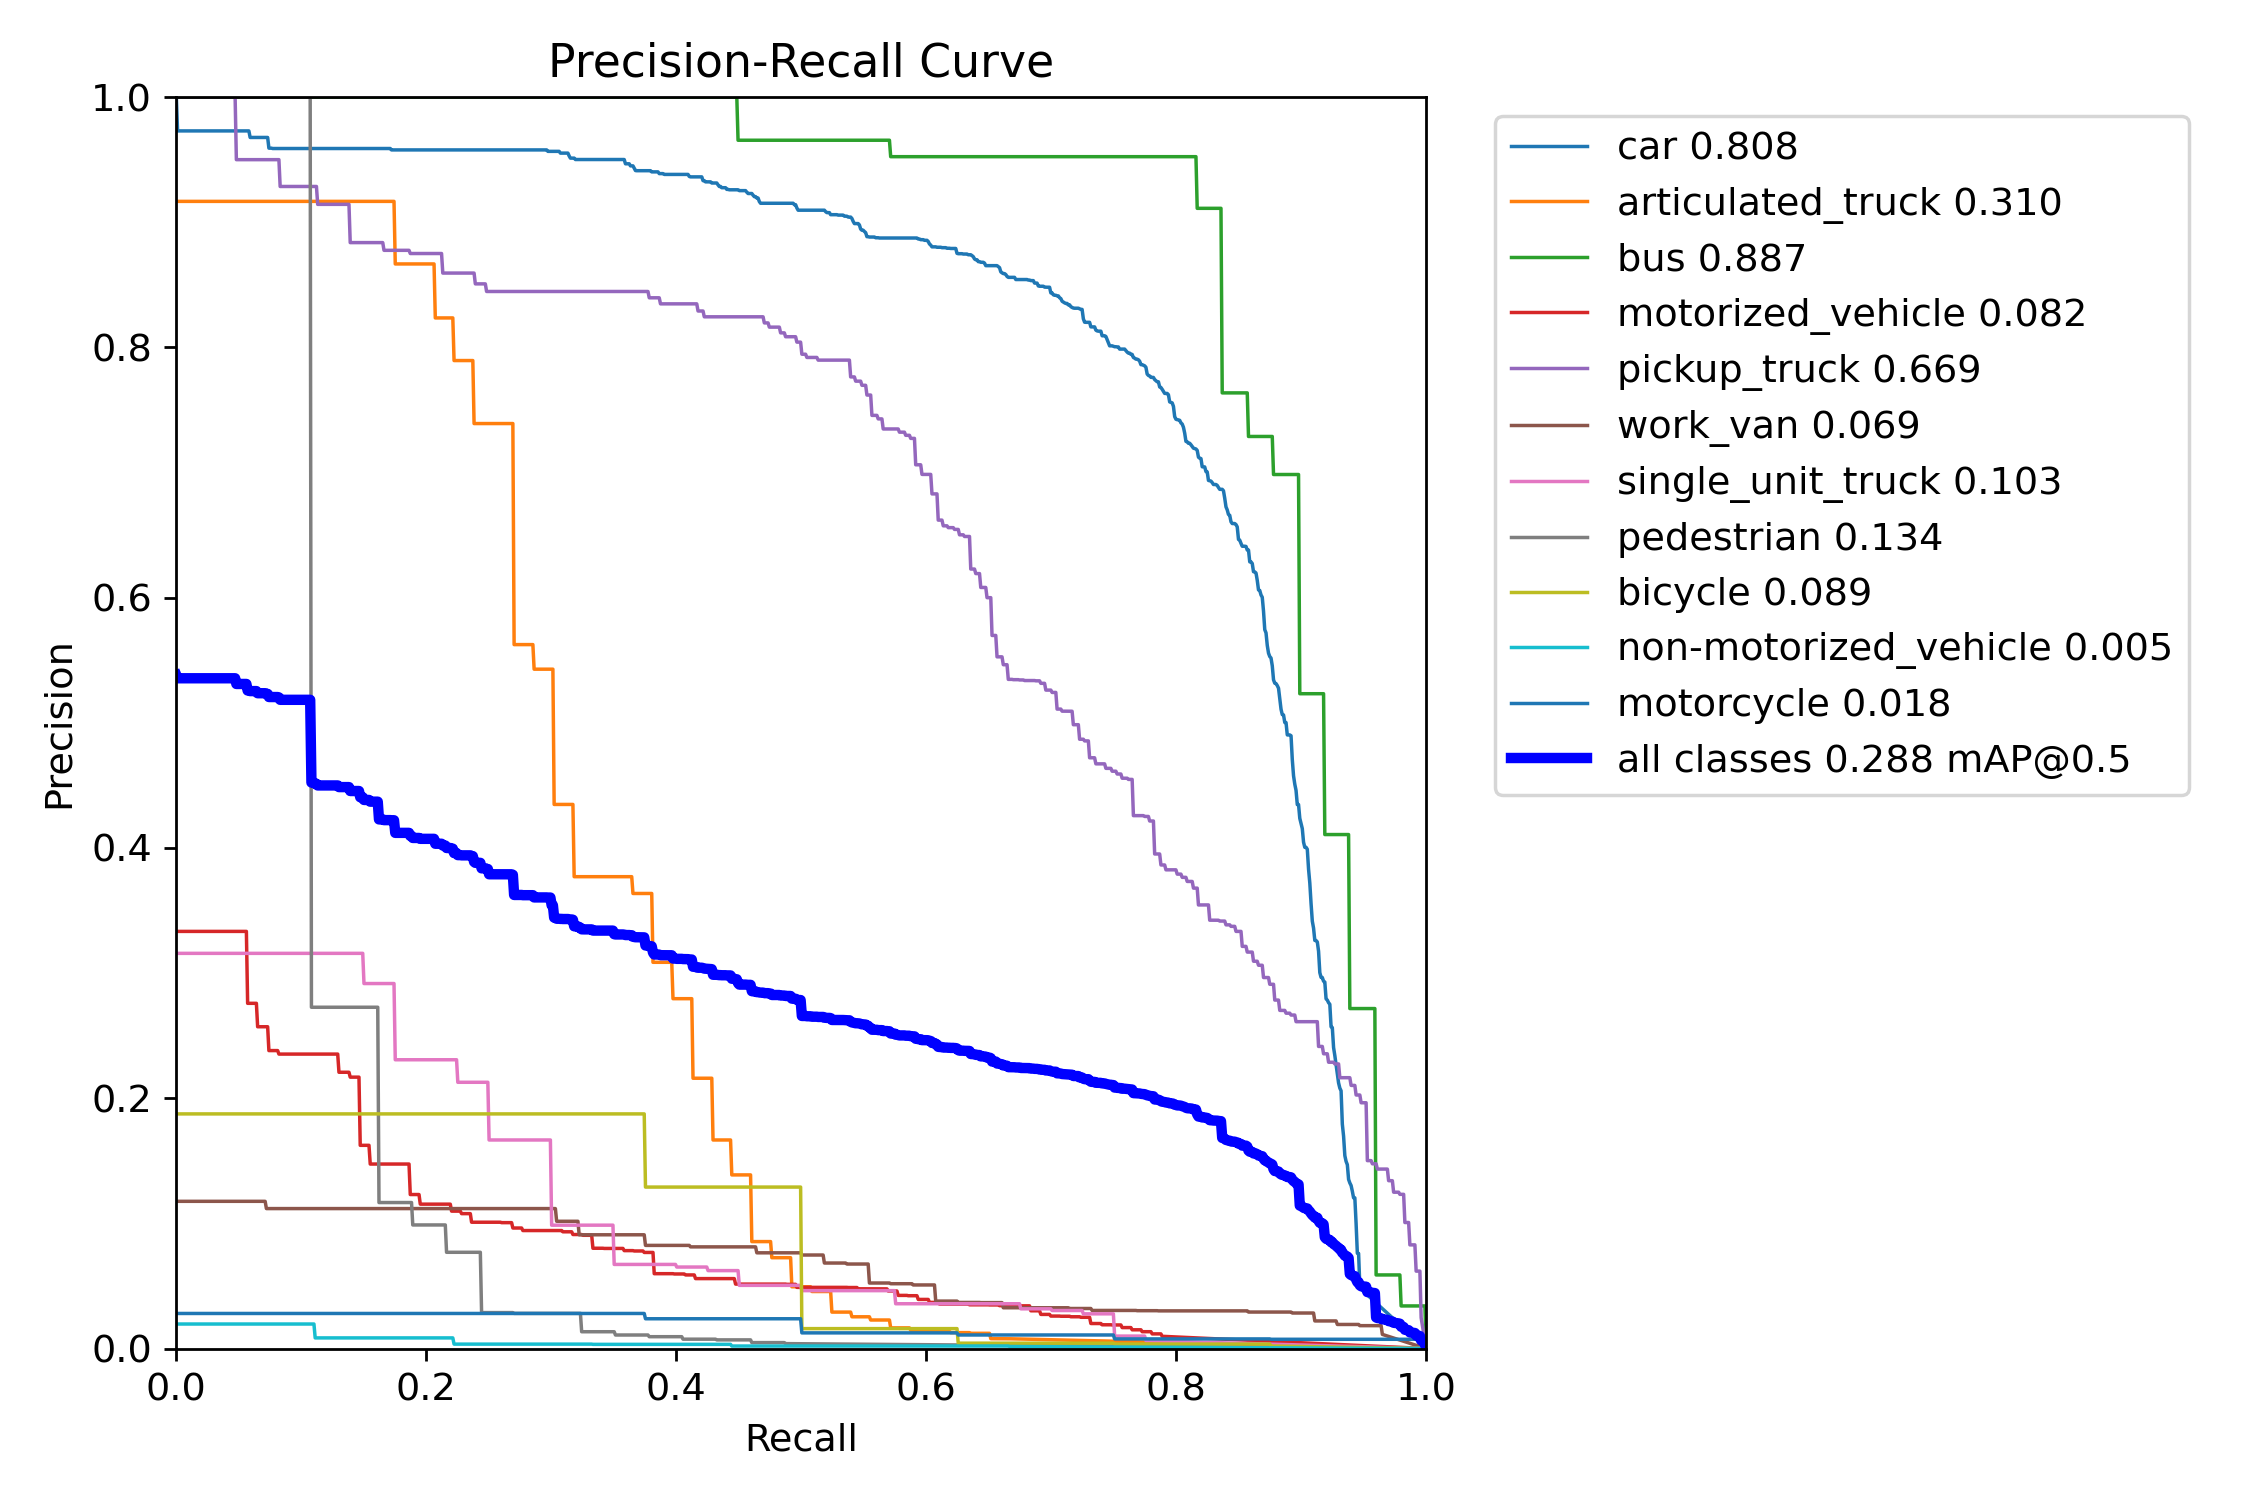

In [27]:
display(Image(filename='/content/yolov5/runs/train/my_custom_run/PR_curve.png', width=800))

# Evaluation conclusion:
- Model performed exceptionally well at bus, car and pickup_truck detection with the highest Average Precision(AP).
- The model has moderately identified the Articulated_truck at 0.310 AP.
- It has performed poorly for other classes

##Summary

An mAP@0.5 of 0.288 (28.8%) suggests that, on average, your model's - performance for detecting all classes at an IoU of 0.5 is fair but indicates considerable room for improvement. The performance is heavily skewed by the strong detection of 'bus' and 'car', while other classes are detected very poorly.

#Run inferences on sample images and see if vehicles are detected accurately


Listing contents of: /content/yolov5/runs/detect/inference_1
Found 558 inference images for display.
Displaying 10 out of 558 inference images.


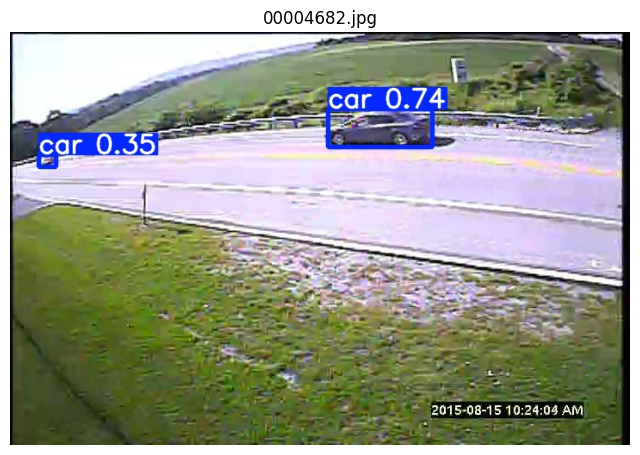

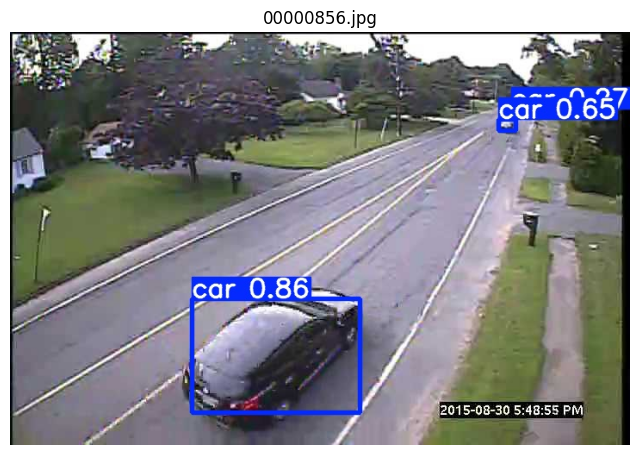

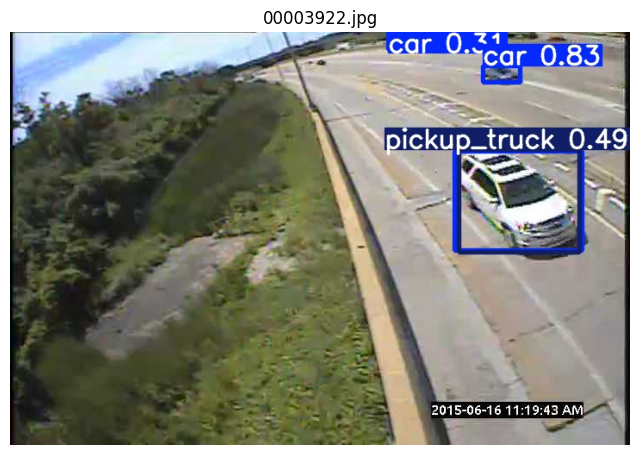

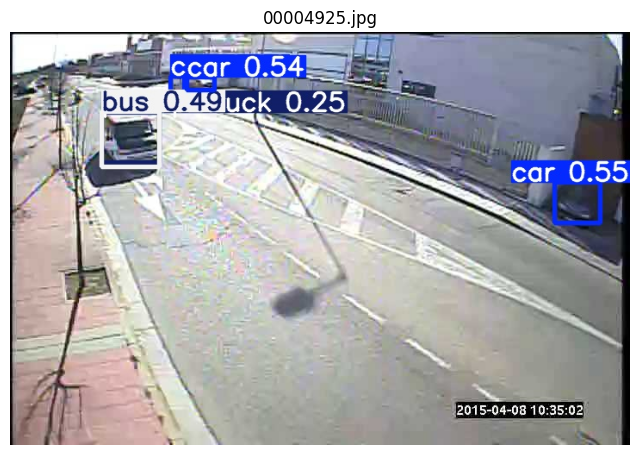

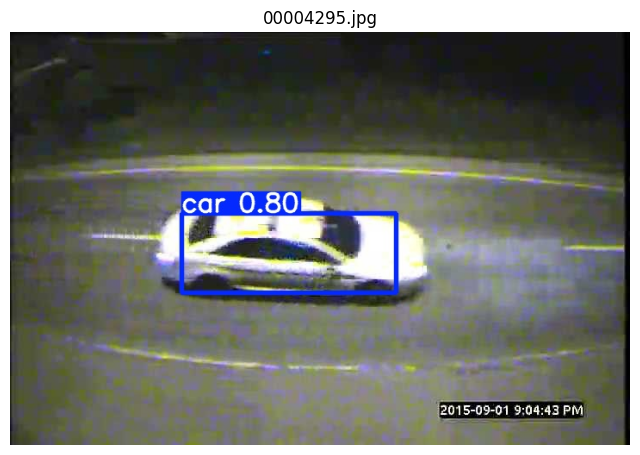

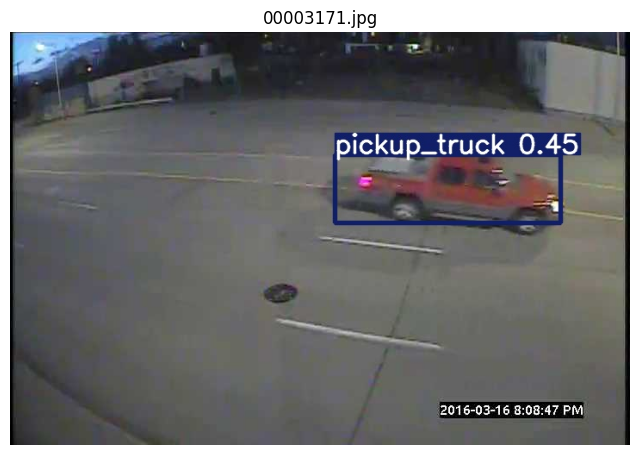

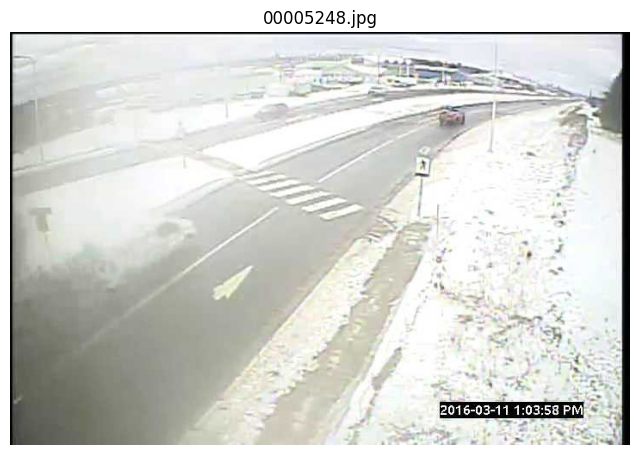

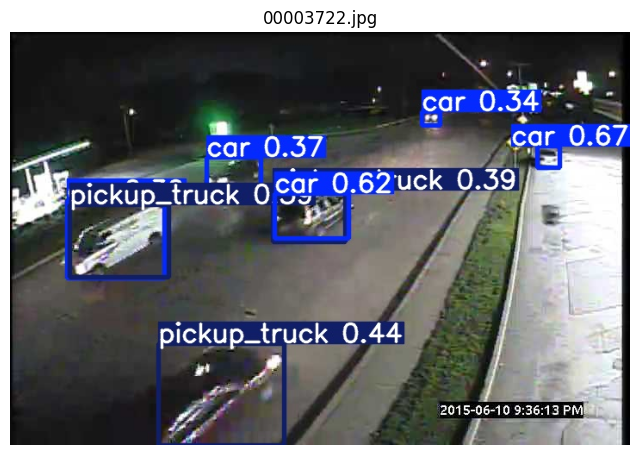

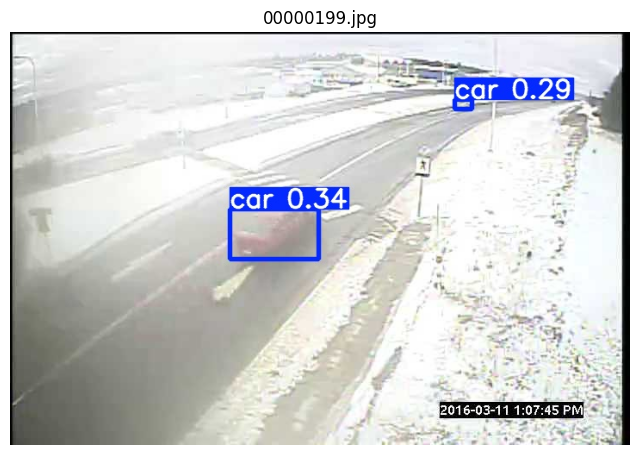

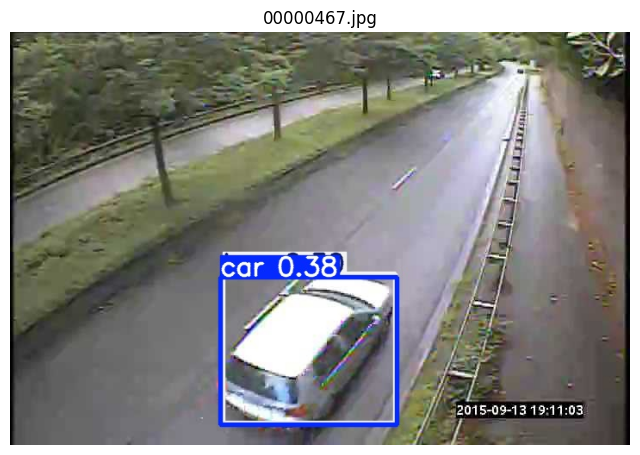


... and 548 more images. Adjust the display loop to see all.


In [33]:
import os
import cv2
import matplotlib.pyplot as plt
import glob
from IPython.display import Image, display

# --- Set variable for the directory ---
INFER_RESULTS_DIR = '/content/yolov5/runs/detect/inference_1'

if not os.path.exists(INFER_RESULTS_DIR):
    print(f"Inference results directory not found: {INFER_RESULTS_DIR}")
else:
    print(f"Listing contents of: {INFER_RESULTS_DIR}")
    #!ls "{INFER_RESULTS_DIR}"

    infer_images = glob.glob(f"{INFER_RESULTS_DIR}/*.jpg") # Assuming .jpg outputs
    print(f"Found {len(infer_images)} inference images for display.")

    if not infer_images:
        print(f"No .jpg images found in {INFER_RESULTS_DIR}.")
    else:
        # Displaying a subset (first 3 images)
        limit = 10 # Define the limit here
        images_to_display = infer_images[:limit] # Slice the list
        print(f"Displaying {len(images_to_display)} out of {len(infer_images)} inference images.")

        for i, pred_image_path in enumerate(images_to_display): # Iterate over the limited list
            #print(f"Displaying: {os.path.basename(pred_image_path)}") # Uncomment if you want individual image filenames
            # For displaying in Colab (optional, but often preferred for many images):
            #display(Image(filename=pred_image_path, width=500)) # Adjust width as needed

            # Using matplotlib for more control, as in your original code:
            image = cv2.imread(pred_image_path)
            if image is not None:
                plt.figure(figsize=(8, 8))
                plt.imshow(image[:, :, ::-1]) # Convert BGR to RGB for matplotlib
                plt.axis('off')
                plt.title(os.path.basename(pred_image_path))
                plt.show()
            else:
                print(f"Warning: Could not read image {pred_image_path}.")

        if len(infer_images) > limit: # Adjust the condition based on 'limit'
            print(f"\n... and {len(infer_images) - limit} more images. Adjust the display loop to see all.")